# Section 2: Input Processing

In this section, we transform raw text into numerical representations that the Transformer can process. We will implement subword tokenization, learnable embeddings, and both Sinusoidal and Rotary positional encodings.


In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import math

torch.manual_seed(42)

# 1. Load Real Data from the Persian-English Corpus
data_path = "../.data/en_fa_train.jsonl"
english_sentences = []

with open(data_path, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        english_sentences.append(data['input'])

print(f"Loaded {len(english_sentences)} sentences.")
print("Sample training text:", english_sentences[1])

Loaded 2047 sentences.
Sample training text: Pack your stuff.


## 1. Subword Tokenization: BPE from Scratch

Subword tokenization like **BPE** allows the model to handle rare words by breaking them into frequent chunks (e.g., "Transformer" -> "Trans", "former").

In [12]:
# Preparation: Use a subset of the data for training
corpus = " ".join(english_sentences[:200])
tokens = [ord(c) for c in corpus]

def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
    newids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

# Training: Perform merging iteratively
num_merges = 100
ids = list(tokens)
merges = {}
for i in range(num_merges):
    stats = get_stats(ids)
    if not stats: break
    pair = max(stats, key=stats.get)
    idx = 256 + i
    ids = merge(ids, pair, idx)
    merges[pair] = idx

print(f"Final compression ratio: {len(tokens) / len(ids):.2f}X")

Final compression ratio: 1.79X


### BPE Visualization: Word Reconstruction
Let's see how BPE captures frequent patterns like suffixes or whole words.

In [13]:
vocab = {i: chr(i) for i in range(256)}
for (p0, p1), v in merges.items():
    vocab[v] = vocab[p0] + vocab[p1]

# Show top 5 learned merges
print("Didactic Check: Top patterns learned by BPE")
for i, (p, idx) in enumerate(list(merges.items())[:5]):
    print(f"[{i+1}] {vocab[p[0]]} + {vocab[p[1]]} -> '{vocab[idx]}'")

Didactic Check: Top patterns learned by BPE
[1] e +   -> 'e '
[2] t +   -> 't '
[3] . +   -> '. '
[4] t + h -> 'th'
[5] o + u -> 'ou'


## 2. Positional Encoding: Representing Order

Transformers are permutation-invariant; they don't know the order of tokens unless we provide it. We inject a **Positional Encoding ($PE$)** vector into each embedding.

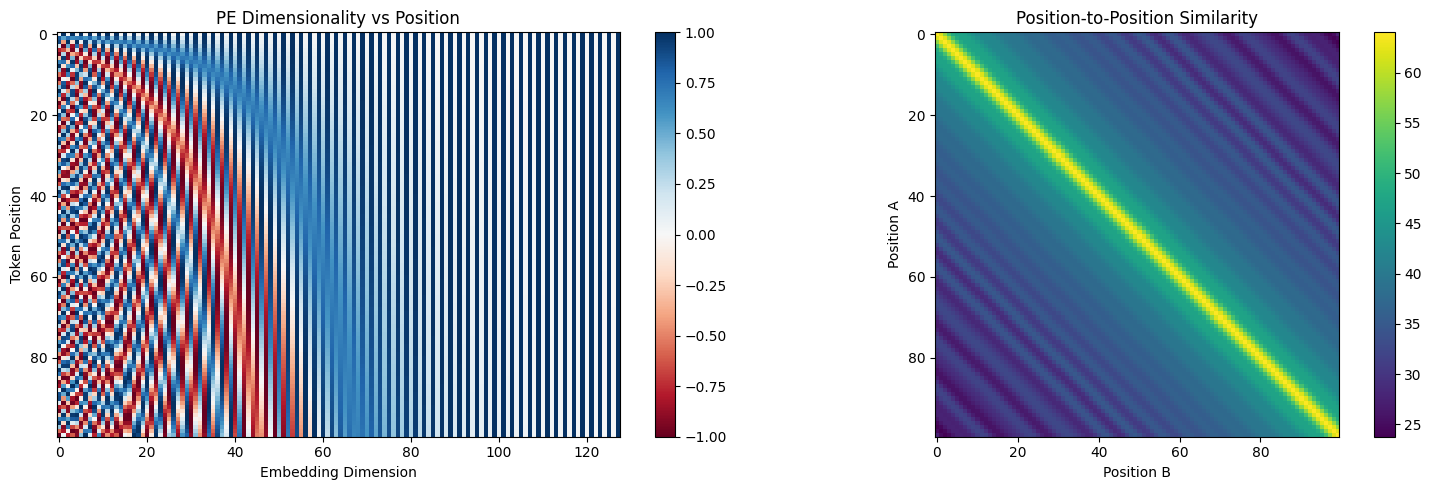

In [14]:
def get_sinusoidal_pe(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    # dim range
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

max_len = 100
d_model = 128
pe_matrix = get_sinusoidal_pe(max_len, d_model)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 2.1 The Patterns: Frequency Heatmap
im0 = ax[0].imshow(pe_matrix.numpy(), aspect='auto', cmap='RdBu')
ax[0].set_title("PE Dimensionality vs Position")
ax[0].set_xlabel("Embedding Dimension")
ax[0].set_ylabel("Token Position")
fig.colorbar(im0, ax=ax[0])

# 2.2 The Logic: Why this works (Distance/Similarity)
# We compute the dot product similarity between position 0 and all other positions
sims = torch.matmul(pe_matrix, pe_matrix.T)
im1 = ax[1].imshow(sims.numpy(), cmap='viridis')
ax[1].set_title("Position-to-Position Similarity")
ax[1].set_xlabel("Position B")
ax[1].set_ylabel("Position A")
fig.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

**Didactic Insight:** In the right plot, the bright diagonal shows that each position is similar to itself. More importantly, the similarity fades smoothly as we move away from the diagonal. This proves that $PE$ encodes **distance**: positions closer together have similar $PE$ vectors, allowing the model to generalize relative order.

## 3. Advanced: Rotary Positional Embeddings (RoPE)

RoPE rotates the query/key vectors in 2D planes. Let's visualize the rotation of a single vector pair as it moves across positions.

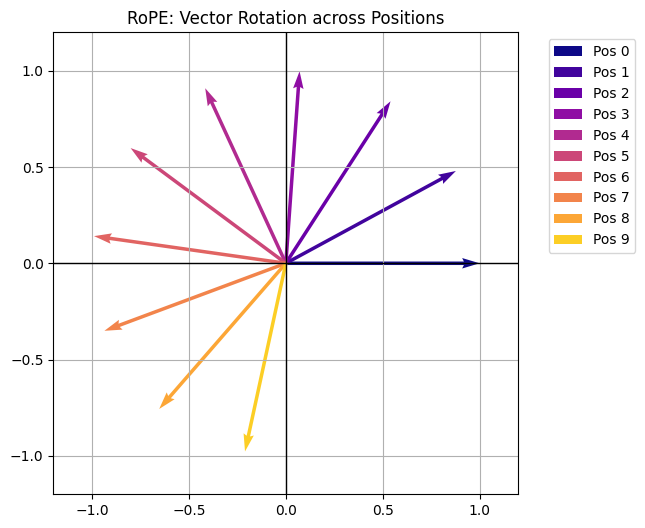

In [15]:
def rotate_2d(vec, theta):
    # Standard 2D rotation matrix logic
    x, y = vec[0], vec[1]
    x_new = x * math.cos(theta) - y * math.sin(theta)
    y_new = x * math.sin(theta) + y * math.cos(theta)
    return np.array([x_new, y_new])

vec = np.array([1.0, 0.0]) # Initial vector at position 0
positions = range(10)
angle_step = 0.5

plt.figure(figsize=(6, 6))
for p in positions:
    rotated = rotate_2d(vec, p * angle_step)
    plt.quiver(0, 0, rotated[0], rotated[1], angles='xy', scale_units='xy', scale=1, 
               label=f'Pos {p}', color=plt.cm.plasma(p/10))

plt.xlim(-1.2, 1.2); plt.ylim(-1.2, 1.2)
plt.axhline(0, color='black', lw=1); plt.axvline(0, color='black', lw=1)
plt.title("RoPE: Vector Rotation across Positions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

**Observation:** Instead of adding a fixed vector, RoPE *multiplies* (rotates) the vector. The distance between tokens is now represented as the **relative angle** between their vectors. This is mathematical magic that preserves the norm of the vectors while encoding position perfectly.